In [206]:
!pip install mediapipe


### Importing all the necessary libraries

In [207]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc


### Loading the dataset

In [208]:
data = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
print("Full train dataset shape is {}".format(data.shape))

Full train dataset shape is (67208, 5)


In [209]:
data.head()

path  file_id  sequence_id  participant_id  \
0  train_landmarks/5414471.parquet  5414471   1816796431             217   
1  train_landmarks/5414471.parquet  5414471   1816825349             107   
2  train_landmarks/5414471.parquet  5414471   1816909464               1   
3  train_landmarks/5414471.parquet  5414471   1816967051              63   
4  train_landmarks/5414471.parquet  5414471   1817123330              89   

                      phrase  
0               3 creekhouse  
1            scales/kuhaylah  
2        1383 william lanier  
3          988 franklin lane  
4  6920 northeast 661st road

### Now let us understand the dataset and how all the files are linked to each other

### Train.csv has an entry for every phrase along with its sequence_id, path, and file_id. The sequence_id is the unique index of the landmark sequence within the landmarks data file, and file_id specifies the file containing the landmarks data for that specific phrase.

### The diagram that follows provides an illustration of how files are related.

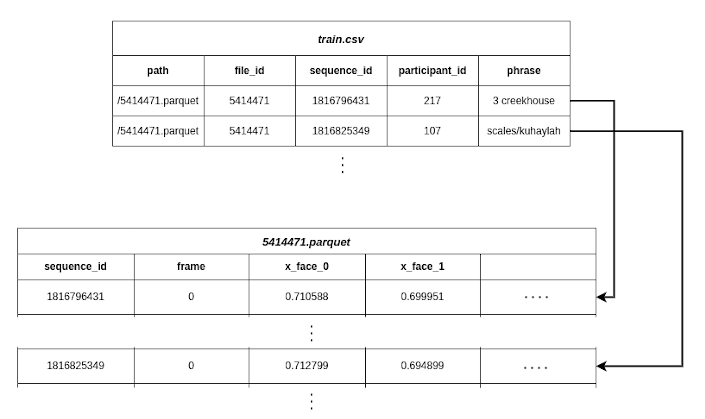


### Now we will examine one example row from landmark file and how it is related with train.csv

In [210]:
# Fetch sequence_id, file_id, phrase from 7th row
sequence_id, file_id, phrase = data.iloc[6][['sequence_id', 'file_id', 'phrase']]
print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")

sequence_id: 1817169529, file_id: 5414471, phrase: https://jsi.is/hukuoka


### Now next we can access the parquet file for particular sequence id in the following manner 

In [212]:
# Fetch data from parquet file
sample_sequence_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
    filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))

Full sequence dataset shape is (300, 1630)


In [213]:
# Now let us this sample_sequence_df 
sample_sequence_df.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1817169529       0  0.740435  0.734038  0.737507  0.723142  0.733195   
1817169529       1  0.743968  0.731306  0.734982  0.720691  0.730481   
1817169529       2  0.735330  0.727608  0.731663  0.717006  0.726665   
1817169529       3  0.741500  0.724301  0.728569  0.714643  0.723468   
1817169529       4  0.738992  0.729264  0.733287  0.718563  0.728307   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1817169529   0.733479  0.735043  0.653469  0.734492  ...        -0.327317   
1817169529   0.730834  0.732612  0.651775  0.732095  ...        -0.280167   
1817169529   0.727005  0.728827  0.648945  0.728236  ...        -0.262822   
1817169529   0.724143  0.726969  0.648704  0.726976  ...        -0.164224   
1817169529   0.728631  0.730391  0.650175  0.729882  ...        -0.161075   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
1817169529         -0.358946        -0.205048        -0.289102   
1817169529         -0.301074        -0.174787        -0.245952   
1817169529         -0.280881        -0.170362        -0.222043   
1817169529         -0.172994        -0.124070        -0.154734   
1817169529         -0.168983        -0.120189        -0.148746   

             z_right_hand_15  z_right_hand_16  z_right_hand_17  \
sequence_id                                                      
1817169529         -0.316426        -0.330475        -0.224326   
1817169529         -0.250015        -0.244606        -0.193371   
1817169529         -0.208816        -0.195668        -0.187259   
1817169529         -0.138793        -0.125200        -0.137634   
1817169529         -0.126287        -0.107934        -0.134492   

             z_right_hand_18  z_right_hand_19  z_right_hand_20  
sequence_id                                                     
1817169529         -0.283333        -0.297210        -0.305664  
1817169529         -0.238736        -0.233796        -0.225342  
1817169529         -0.210144        -0.189974        -0.174090  
1817169529         -0.151121        -0.132724        -0.118861  
1817169529         -0.145703        -0.122515        -0.104440  

[5 rows x 1630 columns]

In [214]:
# Now let us this sample_sequence_df 
sample_sequence_df.head()

frame  x_face_0  x_face_1  x_face_2  x_face_3  x_face_4  \
sequence_id                                                            
1817169529       0  0.740435  0.734038  0.737507  0.723142  0.733195   
1817169529       1  0.743968  0.731306  0.734982  0.720691  0.730481   
1817169529       2  0.735330  0.727608  0.731663  0.717006  0.726665   
1817169529       3  0.741500  0.724301  0.728569  0.714643  0.723468   
1817169529       4  0.738992  0.729264  0.733287  0.718563  0.728307   

             x_face_5  x_face_6  x_face_7  x_face_8  ...  z_right_hand_11  \
sequence_id                                          ...                    
1817169529   0.733479  0.735043  0.653469  0.734492  ...        -0.327317   
1817169529   0.730834  0.732612  0.651775  0.732095  ...        -0.280167   
1817169529   0.727005  0.728827  0.648945  0.728236  ...        -0.262822   
1817169529   0.724143  0.726969  0.648704  0.726976  ...        -0.164224   
1817169529   0.728631  0.730391  0.650175  0.729882  ...        -0.161075   

             z_right_hand_12  z_right_hand_13  z_right_hand_14  \
sequence_id                                                      
1817169529         -0.358946        -0.205048        -0.289102   
1817169529         -0.301074        -0.174787        -0.245952   
1817169529         -0.280881        -0.170362        -0.222043   
1817169529         -0.172994        -0.124070        -0.154734   
1817169529         -0.168983        -0.120189        -0.148746   

             z_right_hand_15  z_right_hand_16  z_right_hand_17  \
sequence_id                                                      
1817169529         -0.316426        -0.330475        -0.224326   
1817169529         -0.250015        -0.244606        -0.193371   
1817169529         -0.208816        -0.195668        -0.187259   
1817169529         -0.138793        -0.125200        -0.137634   
1817169529         -0.126287        -0.107934        -0.134492   

             z_right_hand_18  z_right_hand_19  z_right_hand_20  
sequence_id                                                     
1817169529         -0.283333        -0.297210        -0.305664  
1817169529         -0.238736        -0.233796        -0.225342  
1817169529         -0.210144        -0.189974        -0.174090  
1817169529         -0.151121        -0.132724        -0.118861  
1817169529         -0.145703        -0.122515        -0.104440  

[5 rows x 1630 columns]

### Visualizing data with mediapipe APIs
### Let's utilize the hand landmarker apis of the mediapipe library to visualize the hand landmarks data for the phrase 3 Creek House.

### The main digits on a human hand are represented by hand landmarks.

In [215]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc

# Set matplotlib parameters
plt.rcParams['animation.embed_limit'] = 2**128
plt.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_image_animation(image_list):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(6, 9))
    ax.set_axis_off()

    # Display the first image
    im = ax.imshow(image_list[0], cmap="gray")
    plt.close(fig)

    # Define the animation function
    def animate_frame(frame_idx):
        im.set_array(image_list[frame_idx])
        return [im]

    # Create and return the animation
    animation_obj = animation.FuncAnimation(fig, animate_frame, frames=len(image_list), interval=1000/10)
    return animation_obj


### Now we will be Extracting the landmark data and use the Medipipe library to turn it into a picture. The data is extracted for both hands by this function

In [216]:
import mediapipe
import numpy as np
from mediapipe.framework.formats import landmark_pb2

mp_pose = mediapipe.solutions.pose
mp_hands = mediapipe.solutions.hands
mp_drawing = mediapipe.solutions.drawing_utils
mp_drawing_styles = mediapipe.solutions.drawing_styles

def extract_hand_landmarks(sequence_df):
    hand_images = []
    all_hand_landmarks = []

    for seq_idx in range(len(sequence_df)):
        right_x = sequence_df.iloc[seq_idx].filter(regex="x_right_hand.*").values
        right_y = sequence_df.iloc[seq_idx].filter(regex="y_right_hand.*").values
        right_z = sequence_df.iloc[seq_idx].filter(regex="z_right_hand.*").values

        right_hand_image = np.zeros((600, 600, 3))
        right_hand_landmarks = landmark_pb2.NormalizedLandmarkList()

        for x, y, z in zip(right_x, right_y, right_z):
            right_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
            right_hand_image,
            right_hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
        )

        left_x = sequence_df.iloc[seq_idx].filter(regex="x_left_hand.*").values
        left_y = sequence_df.iloc[seq_idx].filter(regex="y_left_hand.*").values
        left_z = sequence_df.iloc[seq_idx].filter(regex="z_left_hand.*").values

        left_hand_image = np.zeros((600, 600, 3))
        left_hand_landmarks = landmark_pb2.NormalizedLandmarkList()

        for x, y, z in zip(left_x, left_y, left_z):
            left_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
            left_hand_image,
            left_hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
        )

        hand_images.append([right_hand_image.astype(np.uint8), left_hand_image.astype(np.uint8)])
        all_hand_landmarks.append([right_hand_landmarks, left_hand_landmarks])

    return hand_images, all_hand_landmarks


In [217]:
# Extract hand images and landmarks using mediapipe APIs
extracted_images, extracted_landmarks = extract_hand_landmarks(sample_sequence_df)

# Fetch and display the data for the right hand using animation
right_hand_images = np.array(extracted_images)[:, 0]
create_image_animation(right_hand_images)


### Preprocesss the data
We will reorganize the data to include the landmark data and the phrase it represents in each parquet file for efficiency and ease. In this manner, we may avoid alternating between the train.csv and its parquet file.

The updated information will be stored in TFRecord format. A straightforward format for storing a series of binary records is called TFRecord. Using TFRecord to store and load the data is significantly faster and more efficient.

### References 
https://www.kaggle.com/code/irohith/aslfr-preprocess-dataset

https://www.kaggle.com/code/shlomoron/aslfr-parquets-to-tfrecords-cleaned

### Now The primary emphasis of ASL Finger spelling is hand movement. In order to train the model, we will use hand land mark coordinates and hand pose coordinates.


### Now Fetching the pose landmark coordinates related to hand movement.

In [218]:
# Define pose coordinates for hand movement
LEFT_HAND_POSE = [13, 15, 17, 19, 21]
RIGHT_HAND_POSE = [14, 16, 18, 20, 22]
FULL_HAND_POSE = LEFT_HAND_POSE + RIGHT_HAND_POSE


### Creating x,y,z label names from coordinates¶


In [173]:
# Define lists for X, Y, and Z coordinates for hands and pose
X_HAND_RIGHT = [f'x_right_hand_{i}' for i in range(21)]
Y_HAND_RIGHT = [f'y_right_hand_{i}' for i in range(21)]
Z_HAND_RIGHT = [f'z_right_hand_{i}' for i in range(21)]

X_HAND_LEFT = [f'x_left_hand_{i}' for i in range(21)]
Y_HAND_LEFT = [f'y_left_hand_{i}' for i in range(21)]
Z_HAND_LEFT = [f'z_left_hand_{i}' for i in range(21)]

X_POSE = [f'x_pose_{i}' for i in FULL_HAND_POSE]
Y_POSE = [f'y_pose_{i}' for i in FULL_HAND_POSE]
Z_POSE = [f'z_pose_{i}' for i in FULL_HAND_POSE]

# Combine all coordinate lists
X = X_HAND_RIGHT + X_HAND_LEFT + X_POSE
Y = Y_HAND_RIGHT + Y_HAND_LEFT + Y_POSE
Z = Z_HAND_RIGHT + Z_HAND_LEFT + Z_POSE


### Creating the feature columns from the extracted coordinates.



In [174]:
FEATURE_COLUMNS = X + Y + Z


### Storing ids of each coordinate labels to lists



In [175]:
# Identify indices for X, Y, and Z coordinates in FEATURE_COLUMNS
X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "z_" in col]

# Identify indices for right and left hand features in FEATURE_COLUMNS
RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "left" in col]

# Identify indices for right and left pose features in FEATURE_COLUMNS based on RPOSE and LPOSE
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "pose" in col and int(col.split("_")[-1]) in RIGHT_HAND_POSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS) if "pose" in col and int(col.split("_")[-1]) in LEFT_HAND_POSE]


### Now we will be Prepare the dataset and write it as TFRecords.
Let's generate new dataset files and write them as TFRecords using the extracted landmarks and phrases.

It takes about ten minutes to complete. Any further experiments will load the dataset more quickly after this.

In [176]:
import os
import shutil
import tensorflow as tf
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from tqdm import tqdm

# Set length of frames to 128
FRAME_LEN = 128

# Create a directory to store the new data
output_directory = "preprocessed"
if not os.path.isdir(output_directory):
    os.mkdir(output_directory)
else:
    shutil.rmtree(output_directory)
    os.mkdir(output_directory)

# Loop through each file_id
for file_id in tqdm(data.file_id.unique()):
    # Parquet file name
    pq_file = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"
    
    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = data.loc[data["file_id"] == file_id]
    
    # Fetch the parquet file
    parquet_df = pq.read_table(pq_file, columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    
    # File name for the updated data
    tf_file = f"{output_directory}/{file_id}.tfrecord"
    parquet_numpy = parquet_df.to_numpy()
    
    # Initialize the pointer to write the output of each `for loop` below as a sequence into the file.
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        # Loop through each sequence in the file.
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            # Fetch sequence data
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            # Calculate the number of NaN values in each hand landmark
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis=1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis=1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2 * len(phrase) < no_nan:
                features = {FEATURE_COLUMNS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)


100%|██████████| 68/68 [11:40<00:00, 10.31s/it]


### Get the saved TFRecord files into a list

In [219]:
tf_records = data.file_id.map(lambda x: f'/kaggle/working/preprocessed/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")


List of 68 TFRecord files.


### Load character_to_prediction json file
### A character and its value are contained in this JSON file. Three new characters will be added: "P" for padding, "<" and ">" to indicate the beginning and end of each phrase.

In [221]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

# Add pad_token, start pointer and end pointer to the dict
pad_token = 'P'
start_token = '<'
end_token = '>'
pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx
num_to_char = {j:i for i,j in char_to_num.items()}

In [222]:
# Reference: https://www.kaggle.com/code/irohith/aslfr-transformer/notebook

# Function to resize and add padding.
def resize_pad(x):
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x

# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)
    
    # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose
    
    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = resize_pad(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

### Create function to parse data from TFRecord format
### This function will read the TFRecord data and convert it to Tensors.



In [223]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

### Create function to convert the data
### This function transposes and applies masks to the landmark coordinates. It also vectorizes the phrase corresponding to the landmarks using character_to_prediction_index.json.

In [224]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    # Vectorize and add padding.
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    # Apply pre_process function to the landmarks.
    return pre_process(landmarks), phrase

### Train and validation split/Create the final datasets

In [225]:
batch_size = 64
train_len = int(0.8 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

### Create the Transformer model
###  Transformers are designed to process sequential input data , and we have to predict a sentence from a sequence of data.

### We sum position embeddings and token embeddings when processing past target tokens for the decoder.

In [226]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

### Encoder layer for Transformer

In [227]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


### Decoder layer for Transformer

In [228]:
# Customized to add `training` variable
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

### Completing the Transformer model
### This model takes landmark coordinates as inputs and predicts a sequence of characters. The target character sequence, which has been shifted to the left is provided as the input to the decoder during training. The decoder employs its own past predictions during inference to forecast the next token.

### The Levenshtein Distance between sequences is used as the accuracy metric since the evaluation metric for this contest is the Normalized Total Levenshtein Distance.

In [229]:
# Customized to add edit_dist metric and training variable.
# Reference:
# https://www.kaggle.com/code/irohith/aslfr-transformer/notebook
# https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        """Processes one batch inside model.fit()."""
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        # Computes the Levenshtein distance between sequences since the evaluation
        # metric for this contest is the normalized total levenshtein distance.
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

### Now The following callback function is used to display predictions.

In [230]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=60, target_end_token_idx=61
    ):
        """Displays a batch of outputs after every 4 epoch

        Args:
            batch: A test batch
            idx_to_token: A List containing the vocabulary tokens corresponding to their indices
            target_start_token_idx: A start token index in the target vocabulary
            target_end_token_idx: An end token index in the target vocabulary
        """
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 4 != 0:
            return
        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

### Train the Transformer model


In [231]:
# Transformer variables are customized from original keras tutorial to suit this dataset.
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

batch = next(iter(valid_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>']
)  # set the arguments as per vocabulary index for '<' and '>'

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)


optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=4)


Epoch 1/4
    632/Unknown - 461s 716ms/step - loss: 0.8771 - edit_dist: 1.1008target:     <2796 west golden willow drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <1799 westh sth rt rererere>

target:     <9734719887>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <939-614-169-9-9>

target:     <4977236992>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <959-862-6664>

target:     <reallyloud.co.uk/simaii>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <deline comanes>

target:     <kkaicd1.pixnet.net>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <arapsilila.com/>

target:     <8260 john r bowdoin>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <866 winer wan rin>

target:     <56 paper birch drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <460-243-3717>

target:     <gandchudaihardcor.html>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <3009 charingeringe>

target:     <2708 west 77th>PPPPPPPPPPPPPPPPPPPPPPPPPPP

### Plot training loss and validation loss

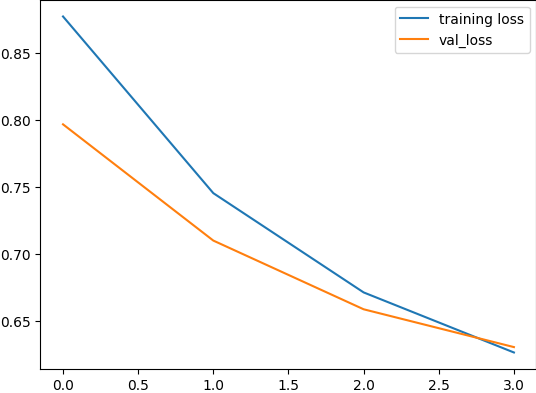

In [232]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'val_loss'])

In [252]:
print("Loss" , history.history['loss'])
print("Val Loss",history.history['val_loss'])

Loss [0.8598212599754333, 0.7288658022880554, 0.6532619595527649, 0.6071434020996094]
Val Loss [0.7823355197906494, 0.6961609125137329, 0.6440673470497131, 0.6108023524284363]


### Creating new model 

In [241]:
import tensorflow as tf
from transformers import TFGPT2Model, GPT2Config
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


!pip install transformers torch


In [242]:
! pip install transformers torch


In [243]:
from tensorflow.keras import layers
import tensorflow as tf


### Now for new model we will be using some previously defined function and will modify them 

# Token Embedding , Land Mark Embedding 

In [244]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

### Modified Encoder Layer 

In [245]:
class ImprovedTransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads*2, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim*2, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

### Modified Decoder Layer 

In [246]:
class ImprovedTransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads*2, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads*2, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.2)
        self.ffn_dropout = layers.Dropout(0.2)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim*2, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        
    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training):
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training=training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training=training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training=training))
        return ffn_out_norm

### Modified Transformer 

In [247]:
class ImprovedTransformer(keras.Model):
    def __init__(
        self,
        num_hid=128,
        num_head=4,
        num_feed_forward=256,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=6,
        num_layers_dec=3,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                ImprovedTransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )

        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                ImprovedTransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")(enc_out, y, training)
        return y

    def call(self, inputs, training):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training)
        y = self.decode(x, target, training)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def test_step(self, batch):        
        source = batch[0]
        target = batch[1]

        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        edit_dist = tf.edit_distance(tf.sparse.from_dense(target), 
                                     tf.sparse.from_dense(tf.cast(tf.argmax(preds, axis=1), tf.int32)))
        edit_dist = tf.reduce_mean(edit_dist)
        self.acc_metric.update_state(edit_dist)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training=False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training=False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

In [ ]:
data.reset_index(drop=True, inplace=True)


In [ ]:
# Transformer variables are customized from original keras tutorial to suit this dataset.
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

batch = next(iter(valid_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch, idx_to_char, target_start_token_idx=char_to_num['<'], target_end_token_idx=char_to_num['>']
)  # set the arguments as per vocabulary index for '<' and '>'

model = ModifiedTransformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)


optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn)

history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=4)


Epoch 1/4
    632/Unknown - 413s 640ms/step - loss: 0.8736 - edit_dist: 1.0555target:     <2796 west golden willow drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <175 stesth peror rd rourd>

target:     <9734719887>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <+63-241-1-19-199-999>

target:     <4977236992>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <949-162-1662>

target:     <reallyloud.co.uk/simaii>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <lale roron hin>

target:     <kkaicd1.pixnet.net>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <https://palalalanean>

target:     <8260 john r bowdoin>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <886 min rororor>

target:     <56 paper birch drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <661-282-3838>

target:     <gandchudaihardcor.html>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <http:///www.hangerom/>

target:     <2708 west 77th>PPPPPPPPPPPPPPPPP

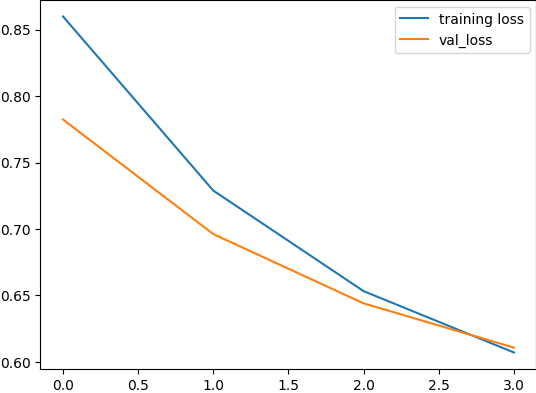

In [249]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'val_loss'])

### Comparison of both models 

### We have modified the transformer model while changing encoder and decoder layer , using different loss fucntions and hyper parameter ans hence modified the original transformer model on comparison we noticed our model performed slightly better than the original model 